In [34]:
# %%
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandapower.networks as nw
from scipy import stats
import pandapower.plotting as plot
import xlsxwriter as xw
import csv
from math import ceil
import os

import pandapower as pp
from pandapower.networks import case1354pegase
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

# %%
# Run the case file and check if there is any error
net = nw.case1354pegase()
# Set the sgen NOT in service
net.sgen.in_service = False
## maximum line and transformer loading percent determine the convergence
# Set maximum line loading percentage
net.line.max_loading_percent = 10000
# Set transformer loading percent as unlimited
net.trafo.max_loading_percent = 1e20
##get load buses from here and the genrator randomly chose 20 percent to be wind buses 
pp.to_excel(net,"case1354pegase.xlsx")      


pp.rundcopp(net)


# %%
############################################################################################

def write_list_to_csv(data_list, filepath):
    """
    Writes a list of items to a CSV file, each item on a new row.
    """
    with open(filepath, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        for item in data_list:
            writer.writerow([item])

# Load the network and disable sgen (assuming renewable sources are sgens)
net = nw.case1354pegase()
net.sgen.in_service = False  # Assuming you want to initially disable all sgens

# Assuming all generators can potentially be renewable generators
# In a real scenario, you might need to filter these based on additional criteria
re_gen_buses = net.gen.bus.values.tolist()

# Select 20% of these generator buses randomly as wind buses
selection_percentage = 0.2
num_wind = int(len(re_gen_buses) * selection_percentage)
wind_buses = random.sample(re_gen_buses, num_wind)

# The remaining 80% are considered thermal buses
thermal_buses = [bus for bus in re_gen_buses if bus not in wind_buses]

# Write these lists to their respective CSV files
write_list_to_csv(wind_buses, 'zones/wind_bus.csv')
write_list_to_csv(thermal_buses, 'zones/thermal_bus.csv')







############################################################################################

# %%
#############################################################################################
#############################################################################################
#############################################################################################
# Get bus
all_bus = np.arange(0, net.bus.shape[0])

# Manually set renewable generator bus 
wind_bus = pd.read_csv('zones/wind_bus.csv', index_col=None, header=None).to_numpy().reshape((-1))
wind_bus = wind_bus - 1 # Bus should be 0-indexed
wind_bidx = np.isin(net.gen.bus.values, wind_bus) # Get the Boolean index of renewable generators

# Get generator bus bidx (slack bus NOT included)
gen_bidx = np.isin(all_bus, net.gen.bus.values)
# Get generator bus no (including renewable, thermal and slack buses)
# slack_gen_no = np.isin(net.bus.name-1, net.gen.bus)

# Get load buses no
load_bidx = np.isin(all_bus, net.load.bus.values)
#############################################################################################


# %%
# The array to store 'p_mw' of net.res_bus
bus_features = ['p_mw']
p_bus_list = np.empty((net.bus.shape[0], len(bus_features)))

# The arrry to store corresponding results 'net.res_gen.p_mw' & 'net.res_gen.va_degree'
# For the time being, we only consider 'p_mw'
# p_gen_features = ['p_mw', 'va_degree']
gen_features = ['p_mw']
p_gen_list = np.empty((net.gen.shape[0]*len(gen_features), 1))
p_max_gen_list = np.empty((net.gen.shape[0], 1))

# The array to store p_mw at load buses
p_load_list = np.empty((net.load.shape[0], 1))

# The array to store corresponding results 'net.res.line...' (there are multiple features in line result).
# Only need to keep the following five features in DC OPF.
# For the time being, we only care about 'p_mw'
# pf_line_features = ['p_from_mw', 'i_ka', 'va_from_degree', 'va_to_degree', 'loading_percent']
line_features = ['p_from_mw']
pf_line_list = np.empty((net.line.shape[0]*len(line_features), 1))
lp_line_list = np.empty((net.line.shape[0], 1))

# The array to store slack bus 'max_p_mw'
p_slack_max_list = []

# Global features
shedding_reserve_list = []
total_cost_list = []
def write_array_to_csv(data_array, file_path):
    """
    Writes an array of data to a CSV file.

    Parameters:
    - data_array: list or numpy.ndarray, the data to write to the CSV file.
    - file_path: str, the path to the output CSV file.
    """
    # Ensure the directory exists; if not, create it
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Open the file in write mode
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Check if data_array is a 1D list or array
        if all(isinstance(item, (list, np.ndarray)) for item in data_array):
            # Data is 2D, write rows as they are
            writer.writerows(data_array)
        else:
            # Data is 1D, write each item in its own row
            for item in data_array:
                writer.writerow([item])

# %%
                
def read_csv_to_array(filepath):
    array = []
    with open(filepath, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            array.append(row[0])
    return array

# def select_random_values(original_array, percentage):
#     num_values_to_select = int(len(original_array) * percentage)
#     return random.sample(original_array, num_values_to_select)

def write_array_to_csv(data_array, filepath):
    with open(filepath, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        for item in data_array:
            writer.writerow([item])

def remove_selected_values(original_array, values_to_remove):
    return [item for item in original_array if item not in values_to_remove]
def partition_list(data_list, num_partitions):
    """Partition data_list into num_partitions roughly equal parts"""
    for i in range(num_partitions):
        yield data_list[i::num_partitions]

def distribute_buses_and_write(buses_list, base_filename, num_zones):
    partitions = list(partition_list(buses_list, num_zones))
    for i, partition in enumerate(partitions, 1):
        filepath = f'zones/zone{i}_{base_filename}.csv'
        write_array_to_csv(partition, filepath)
        
num_zones = 8

# Load previously saved bus lists
load_buses = read_csv_to_array('zones/load_bus.csv')  # Assume this exists
load_buses = [int(value) for value in load_buses]
wind_buses = read_csv_to_array('zones/wind_bus.csv')  # Generated above
wind_buses = [int(value) for value in wind_buses]
thermal_buses = read_csv_to_array('zones/thermal_bus.csv')  # Generated above
thermal_buses = [int(value) for value in thermal_buses]

# Distribute and write to CSV
distribute_buses_and_write(load_buses, "load_bus", num_zones)
distribute_buses_and_write(wind_buses, "wind_bus", num_zones)
distribute_buses_and_write(thermal_buses, "thermal_bus", num_zones)

def combine_and_write_all_and_res_buses(num_zones):
    for i in range(1, num_zones + 1):
        # Read load, wind, and thermal buses for the zone
        load_buses = pd.read_csv(f'zones/zone{i}_load_bus.csv', header=None).squeeze().values.tolist()
        wind_buses = pd.read_csv(f'zones/zone{i}_wind_bus.csv', header=None).squeeze().values.tolist()
        thermal_buses = pd.read_csv(f'zones/zone{i}_thermal_bus.csv', header=None).squeeze().values.tolist()
        
        # Combine wind and thermal buses into RES buses
        res_buses = wind_buses + thermal_buses
        
        # Combine load, wind, and thermal buses into all buses
        all_buses = load_buses + wind_buses + thermal_buses
        
        # Write RES buses to CSV
        write_array_to_csv(res_buses, f'zones/zone{i}_gen_bus.csv')
        
        # Write all buses to CSV
        write_array_to_csv(all_buses, f'zones/zone{i}_bus.csv')

# Execute the function to create the CSVs
combine_and_write_all_and_res_buses(num_zones)







/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packag

In [35]:

# Set number of RVs (Only used for generating plots, DOES NOT HAVE ANY EFFECT ON THE SIMULATION)
num_rv = 1000

# Set distribution parameters
mu = np.array([50, 75, 100, 48, 81, 98, 52, 83])
std = np.array([15, 20, 15, 12, 21, 15, 13, 20])
rv_min = np.array([10, 25, 60, 9, 23, 60, 7, 21])
rv_max = np.array([90, 125, 140, 87, 139, 136, 97, 145])

# Generate distributions and RVs
for i in range(1, num_zones+1):
    # Left / right truncation in terms of standard deviation
    a = (rv_min[i-1] - mu[i-1]) / std[i-1]
    b = (rv_max[i-1] - mu[i-1]) / std[i-1]

    var_name = f'lx{i}'
    globals()[var_name] = np.linspace(rv_min[i-1], rv_max[i-1], num_rv)

    # Generate distributions
    var_name = f'tn{i}'
    globals()[var_name] = stats.truncnorm(loc=mu[i-1], scale=std[i-1], a=a, b=b)

    # Generate random variables and corresponding PDF
    var_name = f'tn_rv{i}'
    globals()[var_name] = globals()[f'tn{i}'].rvs(size=num_rv)
    var_name = f'tn_pdf{i}'
    globals()[var_name] = globals()[f'tn{i}'].pdf(x=globals()[f'lx{i}'])

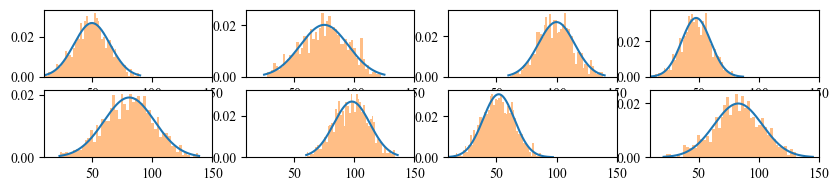

In [36]:
## Plot load RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    ax.plot(globals()[f'lx{i}'], globals()[f'tn_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'tn_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(10, 150)

plt.show()
plt.close('all')

In [37]:
## Define func wind speed --> wind energy
def windSpeedToPower(w):
    """
        input:
            w: wind speed (m/s), ndarray
        output:
            P: wind power (MW), ndarray
    """
    # Check the input type
    if type(w) != np.ndarray:
        raise TypeError("'w' should be 'numpy.ndarray'.")
    # Set maximum allowed wind power generation
    Pr = 100.
    # No wind power if w < wi
    wi = 1.
    # Wind speed that reaches maximum allowed wind power capacity
    wr = 15.
    # Convert wind speed to wind power
    P = Pr*(w**3 - wi**3)/(wr**3 - wi**3)
    # Get index of wind speed less than wi
    left_index = (w < wi)
    P[left_index] = 0.
    # Get index of wind speed bigger than wi
    right_index = (w > wr)
    P[right_index] = Pr

    return P

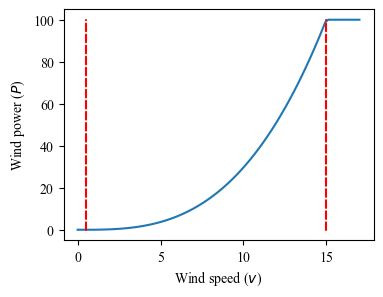

In [38]:
w = np.linspace(0, 17, 100)
P = windSpeedToPower(w)
plt.plot(w, P)
plt.vlines(x=0.5, ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.vlines(x=15., ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.xlabel('Wind speed ($v$)')
plt.ylabel('Wind power ($P$)')
plt.show()
plt.close('all')

In [39]:
# Set parameters
loc = 0.
scale = np.array([8, 8.2, 12, 8.1, 7.9, 7.7, 8, 8.3, 7.8, 8.1, 12.5, 8.5, 7.5, 7.7, 8, 8.3])
shape = np.array([2, 1.8, 8, 1.9, 2.1, 1.9, 2.1, 2.0, 1.8, 1.8, 8.1, 2.2, 1.8, 2.0, 2.0, 2.5])

# Generate distributions and RVs
lx = np.linspace(0, 30, num_rv)
for i in range(1, num_zones+1):
    # Generate distributions
    var_name = f'twb{i}'
    globals()[var_name] = stats.weibull_min(loc=loc, c=shape[i-1], scale=scale[i-1])

    # Generate random variables and corresponding PDF
    var_name = f'twb_rv{i}'
    globals()[var_name] = globals()[f'twb{i}'].rvs(size=num_rv)
    var_name = f'twb_pdf{i}'
    globals()[var_name] = globals()[f'twb{i}'].pdf(x=lx)

    # Conver wind speed to wind power
    var_name = f'wind_power{i}'
    globals()[var_name] = windSpeedToPower(globals()[f'twb_rv{i}'])

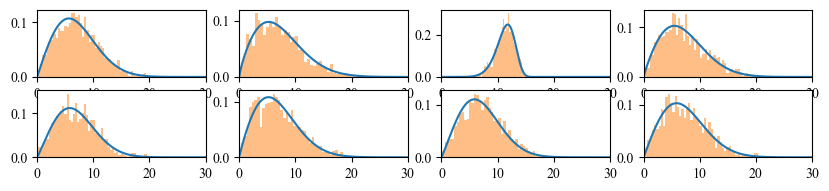

In [40]:
## Plot wind speed RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    ax.plot(lx, globals()[f'twb_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'twb_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 30)

plt.show()
plt.close('all')

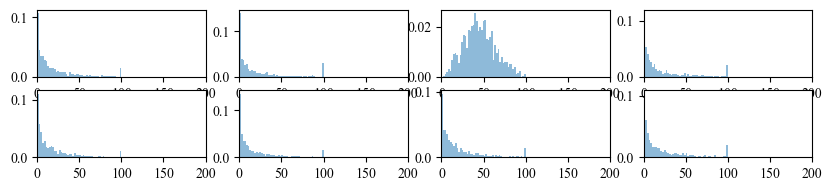

In [41]:
## Plot wind power
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    _, _, _ = ax.hist(globals()[f'wind_power{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 200)

plt.show()
plt.close('all')

In [42]:
num_zones = 8  # Number of zones
os.makedirs('zones', exist_ok=True)  # Ensure the 'zones' directory exists

for i in range(1, num_zones + 1):  # Iterate through each zone
    # Handle load buses
    load_buses_path = f'zones/zone{i}_load_bus.csv'  # Path to load bus IDs file for the zone
    try:
        load_buses = pd.read_csv(load_buses_path, header=None)  # Read load bus IDs from CSV
        num_load_buses = len(load_buses)  # Count the number of load bus IDs
        
        # Generate and normalize proportions for load buses
        load_proportions = np.random.rand(num_load_buses)
        load_proportions /= load_proportions.sum()
        pd.DataFrame(load_proportions).to_csv(f'zones/zone{i}_load_proportion.csv', index=False, header=False)
    except FileNotFoundError:
        print(f"File {load_buses_path} not found. Skipping load buses for zone {i}.")

    # Handle generation (wind) buses
    gen_buses_path = f'zones/zone{i}_wind_bus.csv'  # Path to generation bus IDs file for the zone
    try:
        gen_buses = pd.read_csv(gen_buses_path, header=None)  # Read gen bus IDs from CSV
        num_gen_buses = len(gen_buses)  # Count the number of gen bus IDs
        
        # Generate and normalize proportions for gen (wind) buses
        gen_proportions = np.random.rand(num_gen_buses)
        gen_proportions /= gen_proportions.sum()
        pd.DataFrame(gen_proportions).to_csv(f'zones/zone{i}_wind_proportion.csv', index=False, header=False)
    except FileNotFoundError:
        print(f"File {gen_buses_path} not found. Skipping generation buses for zone {i}.")




In [43]:
## Read correlation matrix
corr_matrix = pd.read_csv('misc/corr_mat.csv', index_col=None, header=None).to_numpy()

## Read load /wind proportions
for i in range(1, num_zones+1):
    var_name = f'zone{i}_load_proportion'
    globals()[var_name] = pd.read_csv(f'zones/zone{i}_load_proportion.csv', 
                                      index_col=None, header=None).to_numpy().reshape((-1))
    
    var_name = f'zone{i}_wind_proportion'   
    globals()[var_name] = pd.read_csv(f'zones/zone{i}_wind_proportion.csv', 
                                      index_col=None, header=None).to_numpy().reshape((-1))

In [59]:
## Number of grid variable samples
max_iteration = 2000

## Numbe rof target OPF samples (solutions)
num_samples = 1000

## Generate correlated RV
# Generate multivariate normal PDF (Standard normal PDF --> covariance = correlation)
mvnorm = stats.multivariate_normal(cov=corr_matrix)
mvnorm_rv = mvnorm.rvs(size=max_iteration)
# Get corresponding CDF (CANNOT USE MULTIVARIATE_NOMRAL CDF)
rv_cdf = stats.norm.cdf(mvnorm_rv)
# Generate RV under target PDFs using inverse CDF
# Generate RV under target PDFs using inverse CDF
for i in range(1, num_zones+1):
    var_name = f'L{i}_ref'
    globals()[var_name] = globals()[f'tn{i}'].ppf(rv_cdf[:, i-1])
    var_name = f'R{i}_ref'
    globals()[var_name] = windSpeedToPower(globals()[f'twb{i}'].ppf(rv_cdf[:, i+num_zones//2]))

In [63]:
# Load gen/load bus in individual zone (globals() dynamicly create variables)
## boolean index use mask 
num_zones = 8
data = {}

for i in range(1, num_zones+1):
    for category in ['load', 'gen', 'wind']:
        bus_csv_path = f'zones/zone{i}_{category}_bus.csv'
        bus_data = pd.read_csv(bus_csv_path, index_col=None, header=None).to_numpy()
        data[f'zone{i}_{category}_bus'] = bus_data

        if category == 'load':
            bidx = np.isin(net.load.bus, bus_data)
        else:  # For gen and wind
            bidx = np.isin(net.gen.bus, bus_data)
        
        data[f'zone{i}_{category}_bidx'] = bidx

In [64]:
 net.load.bus.max()



1352

In [65]:
L_5.shape, zone5_load_bidx.sum()


NameError: name 'L_5' is not defined

In [ ]:
j = 5
for i in range(1, num_zones+1):
    # Generate values for the rest of loads and RES
    var_name = f'L_{i}'
    globals()[var_name] = globals()[f'L{i}_ref'][j] * globals()[f'zone{i}_load_proportion']
    var_name = f'R_{i}'
    globals()[var_name] = globals()[f'R{i}_ref'][j] * globals()[f'zone{i}_wind_proportion']

    # Set p_mw at load buses
    net.load.p_mw[globals()[f'zone{i}_load_bidx']] = globals()[f'L_{i}']

    # # Set max_p_mw adn min_p_mw at wind buses
    # net.gen.max_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']
    # net.gen.min_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']

    print(i)

KeyError: 'zone1_load_bidx'

In [ ]:

# Set RV index
j = 0   # Index for max_iteration
num = 0 # Index for OPF solutions
while j < max_iteration:
    ## Set p_mw at load buses and max_p_mw / min_p_mw at wind buses
    for i in range(1, num_zones+1):
        # Generate values for the rest of loads and RES
        var_name = f'L_{i}'
        globals()[var_name] = globals()[f'L{i}_ref'][j] * globals()[f'zone{i}_load_proportion']
        var_name = f'R_{i}'
        globals()[var_name] = globals()[f'R{i}_ref'][j] * globals()[f'zone{i}_wind_proportion']

        # Set p_mw at load buses
        net.load.p_mw[globals()[f'zone{i}_load_bidx']] = globals()[f'L_{i}']

        # Set max_p_mw adn min_p_mw at wind buses
        net.gen.max_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']
        net.gen.min_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']
    
    # Set 'max_p_mw' at slack bus 
    if net.load.p_mw.sum() >= net.gen.max_p_mw.sum():
        net.ext_grid.max_p_mw = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
    else:
        net.ext_grid.max_p_mw = 0.

    ## Run OPF solver (ignore unconverged cases) and collect data
    try:
        ## Run DCOPP
        pp.rundcopp(net)

        ## Collect data
        # p_mw at load buses
        p_load = net.load.p_mw.to_numpy().reshape((-1, 1))
        p_load_list = np.concatenate([p_load_list, p_load], axis=1)
        # max_p_mw at gen buses
        p_max_gen = net.gen.max_p_mw.to_numpy().reshape((-1, 1))
        p_max_gen_list = np.concatenate([p_max_gen_list, p_max_gen], axis=1)
        # max_p_mw at slack bus
        p_slack_max_list.append(net.ext_grid.max_p_mw.values)

        ## Collect results
        # Results of p_mw at all buses
        # order='F' means first index changes fastest while last index changes slowest
        p_bus = net.res_bus[bus_features].to_numpy().reshape((-1, len(bus_features)), order='F') 
        p_bus_list = np.concatenate([p_bus_list, p_bus], axis=1)
        # Results of p_mw at gen buses
        p_gen = net.res_gen[gen_features].to_numpy().reshape((-1, 1), order='F')  
        p_gen_list = np.concatenate([p_gen_list, p_gen], axis=1)
        # Results of power flow at all lines
        pf_line = net.res_line[line_features].to_numpy().reshape((-1, 1), order='F')
        pf_line_list = np.concatenate([pf_line_list, pf_line], axis=1)
        # Results of loading percent at all lines
        lp_line = net.res_line.loading_percent.to_numpy().reshape((-1, 1))
        lp_line_list = np.concatenate([lp_line_list, lp_line], axis=1)
        # Results of shedding and reserve
        shedding_reserve = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
        shedding_reserve_list.append(shedding_reserve)
        # Results of total cost
        total_cost = net.res_cost / 1e3
        total_cost_list.append(total_cost)

        # Increment index
        num += 1

        if num >= num_samples:
            print(f'{num_samples} OPF solutions found')
            break
    except:
        print(f'No solution found for sample {j+1}')
        pass

    # Increment index
    j += 1

    # Increment index
    if j >= max_iteration:
        print(f'No sufficient samples found for {num_samples} OPF solutions')
        break


KeyError: 'zone1_load_bidx'

In [ ]:
# Save synthetic data (node level)
pd.DataFrame(p_load_list[:, 1:]).to_csv('synthetic_data/p_load_data.csv')
pd.DataFrame(p_max_gen_list[:, 1:]).to_csv('synthetic_data/p_max_gen_data.csv')
pd.DataFrame(p_slack_max_list).to_csv('synthetic_data/p_slack_max_data.csv')
pd.DataFrame(p_bus_list[:, len(bus_features):]).to_csv('synthetic_data/p_bus_data.csv')
pd.DataFrame(p_gen_list[:, 1:]).to_csv('synthetic_data/p_gen_data.csv')

# Save synthetic data (edge level)
pd.DataFrame(pf_line_list[:, 1:]).to_csv('synthetic_data/pf_line_data.csv')
pd.DataFrame(lp_line_list[:, 1:]).to_csv('synthetic_data/lp_line_data.csv')

pd.DataFrame(lp_line_list[:, 1:]).to_csv('reliability_risk/lp_true_corr.csv')

# Save synthetic data (graph level)
graph_features = pd.concat([pd.Series(shedding_reserve_list, name='shedding_reserve'), 
                           pd.Series(total_cost_list, name='total_cost(10^3)')], 
                           axis=1)
graph_features.T.to_csv('synthetic_data/graph_features.csv')

In [ ]:
lp_line = pd.DataFrame(lp_line_list[:, 1:])

In [ ]:
_, _, _ = plt.hist(lp_line.values.flatten(), bins=50, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close('all')